# Nino3.4 index for control run

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from scipy.signal import detrend
from matplotlib import pyplot as plt
from scipy import signal

import xarray as xr
import intake
import pprint 

# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
import util 

In [2]:
if util.is_ncar_host():
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")
col;

In [6]:
# piControl
cat = col.search(experiment_id = 'piControl', variable_id='ts', source_id='CESM2',table_id='Amon')
cat.df
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True}, cdf_kwargs={'chunks': {}})
dset_dict.keys()


xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)


dict_keys(['CMIP.NCAR.CESM2.piControl.Amon.gn'])

In [7]:
control_ds = dset_dict['CMIP.NCAR.CESM2.piControl.Amon.gn']

In [9]:
def area_weights(lat_bnds, lon_bnds): # computes exact areas assuming earth is a perfect sphere
    lowerlats = np.radians(lat_bnds[:,0]); upperlats = np.radians(lat_bnds[:,1])
    difflon = np.radians(np.diff(lon_bnds[0,:])) # if the differences in longitudes are all the same
    areaweights = difflon*(np.sin(upperlats) - np.sin(lowerlats));
    areaweights /= areaweights.mean()
    return areaweights # list of weights, of same dimension as latitude

In [28]:
ts_clim = control_ds.ts.groupby('time.month').mean(dim='time')
ts_anom = control_ds.ts.groupby('time.month') - ts_clim
weights = area_weights(control_ds['lat_bnds'], control_ds['lon_bnds'])
gl_mean_anom = (ts_anom * weights).mean(dim=['lon', 'lat'])

#ts_anom_detrended = xr.apply_ufunc(detrend, ts_anom, kwargs={'axis': 1}, dask = 'allowed')

## Plot global mean anomaly:

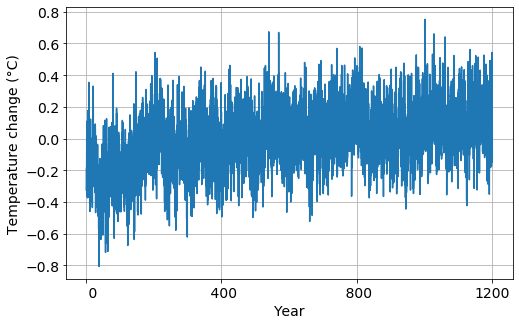

In [29]:
times = gl_mean_anom.isel(member_id=0)['time']
data = gl_mean_anom.isel(member_id=0)

fig, ax = plt.subplots(figsize = (8,5))
plt.plot(times, data);
plt.grid()
plt.tick_params(axis='both', labelsize = 14)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Temperature change (°C)', fontsize = 14);


In [ ]:
# requires too much memory to do this? 

#gl_mean_anom.isel(member_id=0).plot()

## Compute average anomaly over Nino 3.4 region

In [31]:
nino34_ts = ts_anom.sel(lat=slice(-5, 5), lon=slice(190, 240))

# Compute a moving temporal average
nino34_mean = (nino34_ts * weights.sel(lat=slice(-5, 5))).mean(dim=('lon', 'lat'))
nino34_index = nino34_mean.rolling(time=3, center=True).mean()


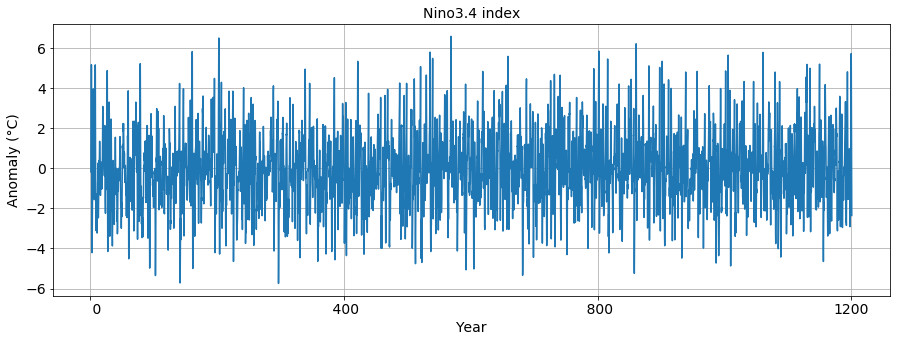

In [38]:
fig, axes = plt.subplots(figsize = (15,5))

#nino34_index.plot.line(ax = axes, x = 'time')
axes.plot(times,nino34_index.isel(member_id = 0))
plt.grid()
plt.ylabel('Anomaly (°C)', fontsize = 14);
axes.set_title('Nino3.4 index', fontsize = 14);
plt.tick_params(axis='both', labelsize = 14)
plt.xlabel('Year', fontsize = 14);